In [1]:
import numpy as np 
import matplotlib.pyplot as plt 

import torch
import torch.nn as nn
import torch.optim as optim

from data_generation import generate_data
from models import OneHiddenRelu, SpikyModel, DeepRelu
from trainer import train_neural_model

# Expérience 1

L'objectif de cette expérience est de vérifier la consistance de la prédiction d'un réseau de neurones à une couche cachée très large avec la fonction d'activation spiky-smooth. 

Pour cela, nous allons créer n datasets chacun composé de couples $(X_i, Y_i)$ toujours tiré selon la même méthode. Les $X_i$ sont tirés selon une loi uniforme sur $[0, 1]$ et les $Y_i = cos(2 \pi \omega X_i) + N(0, \sigma^2)$. 

Ainsi, pour ces 10 datasets, nous allons estimer la variance et la MSE. 

A travers notre expérience, l'objectif est de voir si les objectifs de "benign overfitting" sont atteints. En effet, si le modèle peut overfit le bruit mais effectuer des prédictions en se "débarassant" du bruit, nous pourrons parler d'un overfitting bénin. Pour cela, nous nous attendons à observer très faible de notre estimateur. 

## Paramètres de l'expérience

In [2]:
# parameters for the generating trianing data 
n_datasets = 20  # nb of datasets to generate
n_points = 12  # nb of training data points
omega = 1.5  # freqeuncy of cosinus for train set
deterministic = True  # X_i deterministic or not
noise_scale = .5  # noise of data

# parameters for testing data
n_test_points = 50  # nb of test data points 

# parameters of models & training 
hidden_size = 2000  # size of hidden layer of spiky model
freq = 400  # freq of spiky-smooth actvation function 
num_epochs = 4000

## Generation des données 

In [3]:
# make a generator of datasets
def data_generator(n_points=n_points, n_datasets=n_datasets):
    for _ in range(n_datasets):
        yield generate_data(n_points, 
                            noise_scale=noise_scale, 
                            deterministic=deterministic, 
                            freq=omega)

## Début de l'expérience

In [4]:
# define testing points 
testing_points = np.linspace(0, 1, n_test_points).reshape(n_test_points, 1)
X_test = torch.tensor(testing_points, dtype=torch.float32)

# store value on testing points
relu_pred = np.zeros((n_datasets, n_test_points), dtype=np.float32)
spiky_pred = np.zeros((n_datasets, n_test_points), dtype=np.float32)

In [5]:
i = 0
for data in data_generator():

    # get data 
    X, y = data

    # define models
    relu_model = OneHiddenRelu(X.shape[-1], hidden_size=1000)
    spiky_model = SpikyModel(freq=freq, 
                             input_size=X.shape[-1], 
                             hidden_size=hidden_size, 
                             output_size=1)
    
    # train models 
    relu_model = train_neural_model(relu_model, X, y, num_epochs=num_epochs)
    spiky_model = train_neural_model(spiky_model, X, y, num_epochs=num_epochs)

    # make predictions 
    relu_pred[i, :] = relu_model(X_test).detach().numpy().T[0]
    spiky_pred[i, :] = spiky_model.inference(X_test).detach().numpy().T[0]

    # update 
    i += 1
    print(f"{i}/{n_datasets} iterations done.")


d:\MOI\CentraleSupelec\Cours CS\3A\SDI\TDL\projet\code\data_generation.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(np.cos(X * 2 * freq * np.pi) + noise, dtype=torch.float32)


1/20 iterations done.


d:\MOI\CentraleSupelec\Cours CS\3A\SDI\TDL\projet\code\data_generation.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(np.cos(X * 2 * freq * np.pi) + noise, dtype=torch.float32)


2/20 iterations done.
3/20 iterations done.
4/20 iterations done.
5/20 iterations done.
6/20 iterations done.
7/20 iterations done.
8/20 iterations done.
9/20 iterations done.
10/20 iterations done.
11/20 iterations done.
12/20 iterations done.
13/20 iterations done.
14/20 iterations done.
15/20 iterations done.
16/20 iterations done.
17/20 iterations done.
18/20 iterations done.
19/20 iterations done.
20/20 iterations done.


Nous pouvons maintenant évaluer la moyenne et la variance de chacune des deux méthodes en tous les points du dataset.

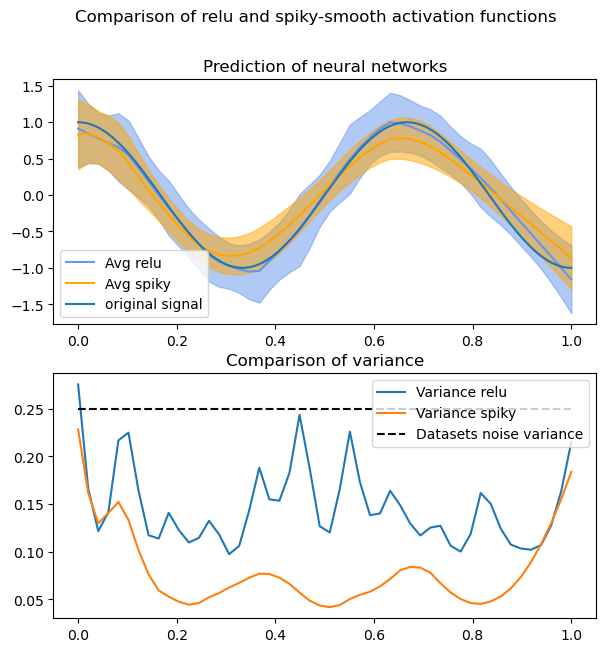

In [10]:
# compute mean at each point 
mean_relu = np.mean(relu_pred, axis=0)
mean_spiky = np.mean(spiky_pred, axis=0)

# compute variance at each point 
var_relu = np.var(relu_pred, axis=0)
var_spiky = np.var(spiky_pred, axis=0)

# add std on plot 
mean_relu_error_0 = mean_relu - np.sqrt(var_relu)
mean_relu_error_1 = mean_relu + np.sqrt(var_relu)
mean_spiky_error_0 = mean_spiky - np.sqrt(var_spiky)
mean_spiky_error_1 = mean_spiky + np.sqrt(var_spiky)

# construct theoretical signal 
x_ = np.linspace(0, 1., 100)
y_ = np.cos(x_ * 2 * omega * np.pi)

x = testing_points.reshape(len(testing_points))

# plot results 

fig, ax = plt.subplots(2, 1, figsize=(7, 7))

ax[0].plot(testing_points, mean_relu, color="cornflowerblue", label="Avg relu")
ax[0].fill_between(x, mean_relu_error_0, mean_relu_error_1, color='cornflowerblue', alpha=0.5)
ax[0].plot(testing_points, mean_spiky, color="orange", label="Avg spiky")
ax[0].fill_between(x, mean_spiky_error_0, mean_spiky_error_1, color='orange', alpha=0.5)
ax[0].plot(x_, y_, label="original signal")
ax[0].set_title("Prediction of neural networks")

ax[1].plot(testing_points, var_relu, label="Variance relu")
ax[1].plot(testing_points, var_spiky, label="Variance spiky")
ax[1].hlines(0.25, xmin=0, xmax=1, linestyle='--', color="black", label="Datasets noise variance")
ax[1].set_title("Comparison of variance")

fig.suptitle("Comparison of relu and spiky-smooth activation functions")

ax[0].legend()
ax[1].legend()

plt.show()

Conclusion de cette première expérience: 

Nous avons donc entraîner deux réseaux de neurones sur 20 datasets différents mais de même signal a capturé jusqu'à overfitting. Idéalement, si spiky-relu permet un overfitting bénin, le signal prédit par ce réseau de neurones devrait toujours être le même (seul le bruit change dans les différentes expériences). Nous nous attendons donc deux choses. D'une part, que le signal prédit moyen par les deux réseaux de neurons (spiky-relu et relu) soient le bon signal. Le bruit étant gaussien, l'espérance des différentss signaux doivent être le signal d'origine. D'autre part, la variance du réseau "spiky-relu" doit être plus faible que celle du réseau relu. En effet, comme le réseau spiky-relu doit idéalement prédire toujours le même signal, sa variance théorique devrait être 0. 

Premièrement, nous pouvons observer sur le premier graphe que la moyenne des signaux est proche du signal à prédire. Cela montre que les deux réseaux de neurones ont capturé le bon signal. Cependant, on peuut noter que l'espérance de spiky-relu est un peu moins bonne que relu et nécessite sans doute plus d'opitmisation de l'hyperparamètre "fréquence" de spiky-relu.

Deuxièmement, la variance du réseau spiky-relu est bien plus faible que celui avec relu. Cela montre un résultat que nous attendions. Spiky-relu est moins sensible au bruit et généralise bien: le signal extrait par spiky-relu est peu sensible au bruit. 

On pourra tout de même noter que nous avons eu besoin d'opitmiser l'hyperparamètre de la fonction d'activation spiky-relu. Cela nous mène à la seconde expérience: l'influence de cet hyperparamètre sur l'overftitting bénin.

### Experience 2

In [64]:
# parameters for the generating trianing data 
n_points = 20  # nb of training data points
omega = 1.5  # freqeuncy of cosinus for train set
deterministic = True  # X_i deterministic or not
noise_scale = .25  # noise of data

# parameters for testing data
n_test_points = 50  # nb of test data points 

# parameters of models & training 
hidden_size = 2000  # size of hidden layer of spiky model
freq = [10, 50, 100, 200, 400, 1000, 2000, 4000]  # freq of spiky-smooth actvation function 
num_epochs = 4000

In [65]:
# define testing points 
testing_points = np.linspace(0, 1, n_test_points).reshape(n_test_points, 1)
X_test = torch.tensor(testing_points, dtype=torch.float32)

# store value on testing points
raw_pred = np.zeros((len(freq), n_test_points), dtype=np.float32)
signal_pred = np.zeros((len(freq), n_test_points), dtype=np.float32)

# generate data 
data = generate_data(n_points, 
                     noise_scale=noise_scale, 
                     deterministic=deterministic, 
                     freq=omega)

In [66]:
i = 0
for f in freq:

    # define models
    spiky_model = SpikyModel(freq=f, 
                             input_size=X.shape[-1], 
                             hidden_size=hidden_size, 
                             output_size=1)
    
    # train models 
    spiky_model = train_neural_model(spiky_model, X, y, num_epochs=num_epochs)

    # make predictions 
    raw_pred[i, :] = spiky_model(X_test).detach().numpy().T[0]
    signal_pred[i, :] = spiky_model.inference(X_test).detach().numpy().T[0]

    # update 
    i += 1
    print(f"{i}/{len(freq)} iterations done.")


1/8 iterations done.
2/8 iterations done.
3/8 iterations done.
4/8 iterations done.
5/8 iterations done.
6/8 iterations done.
7/8 iterations done.
8/8 iterations done.


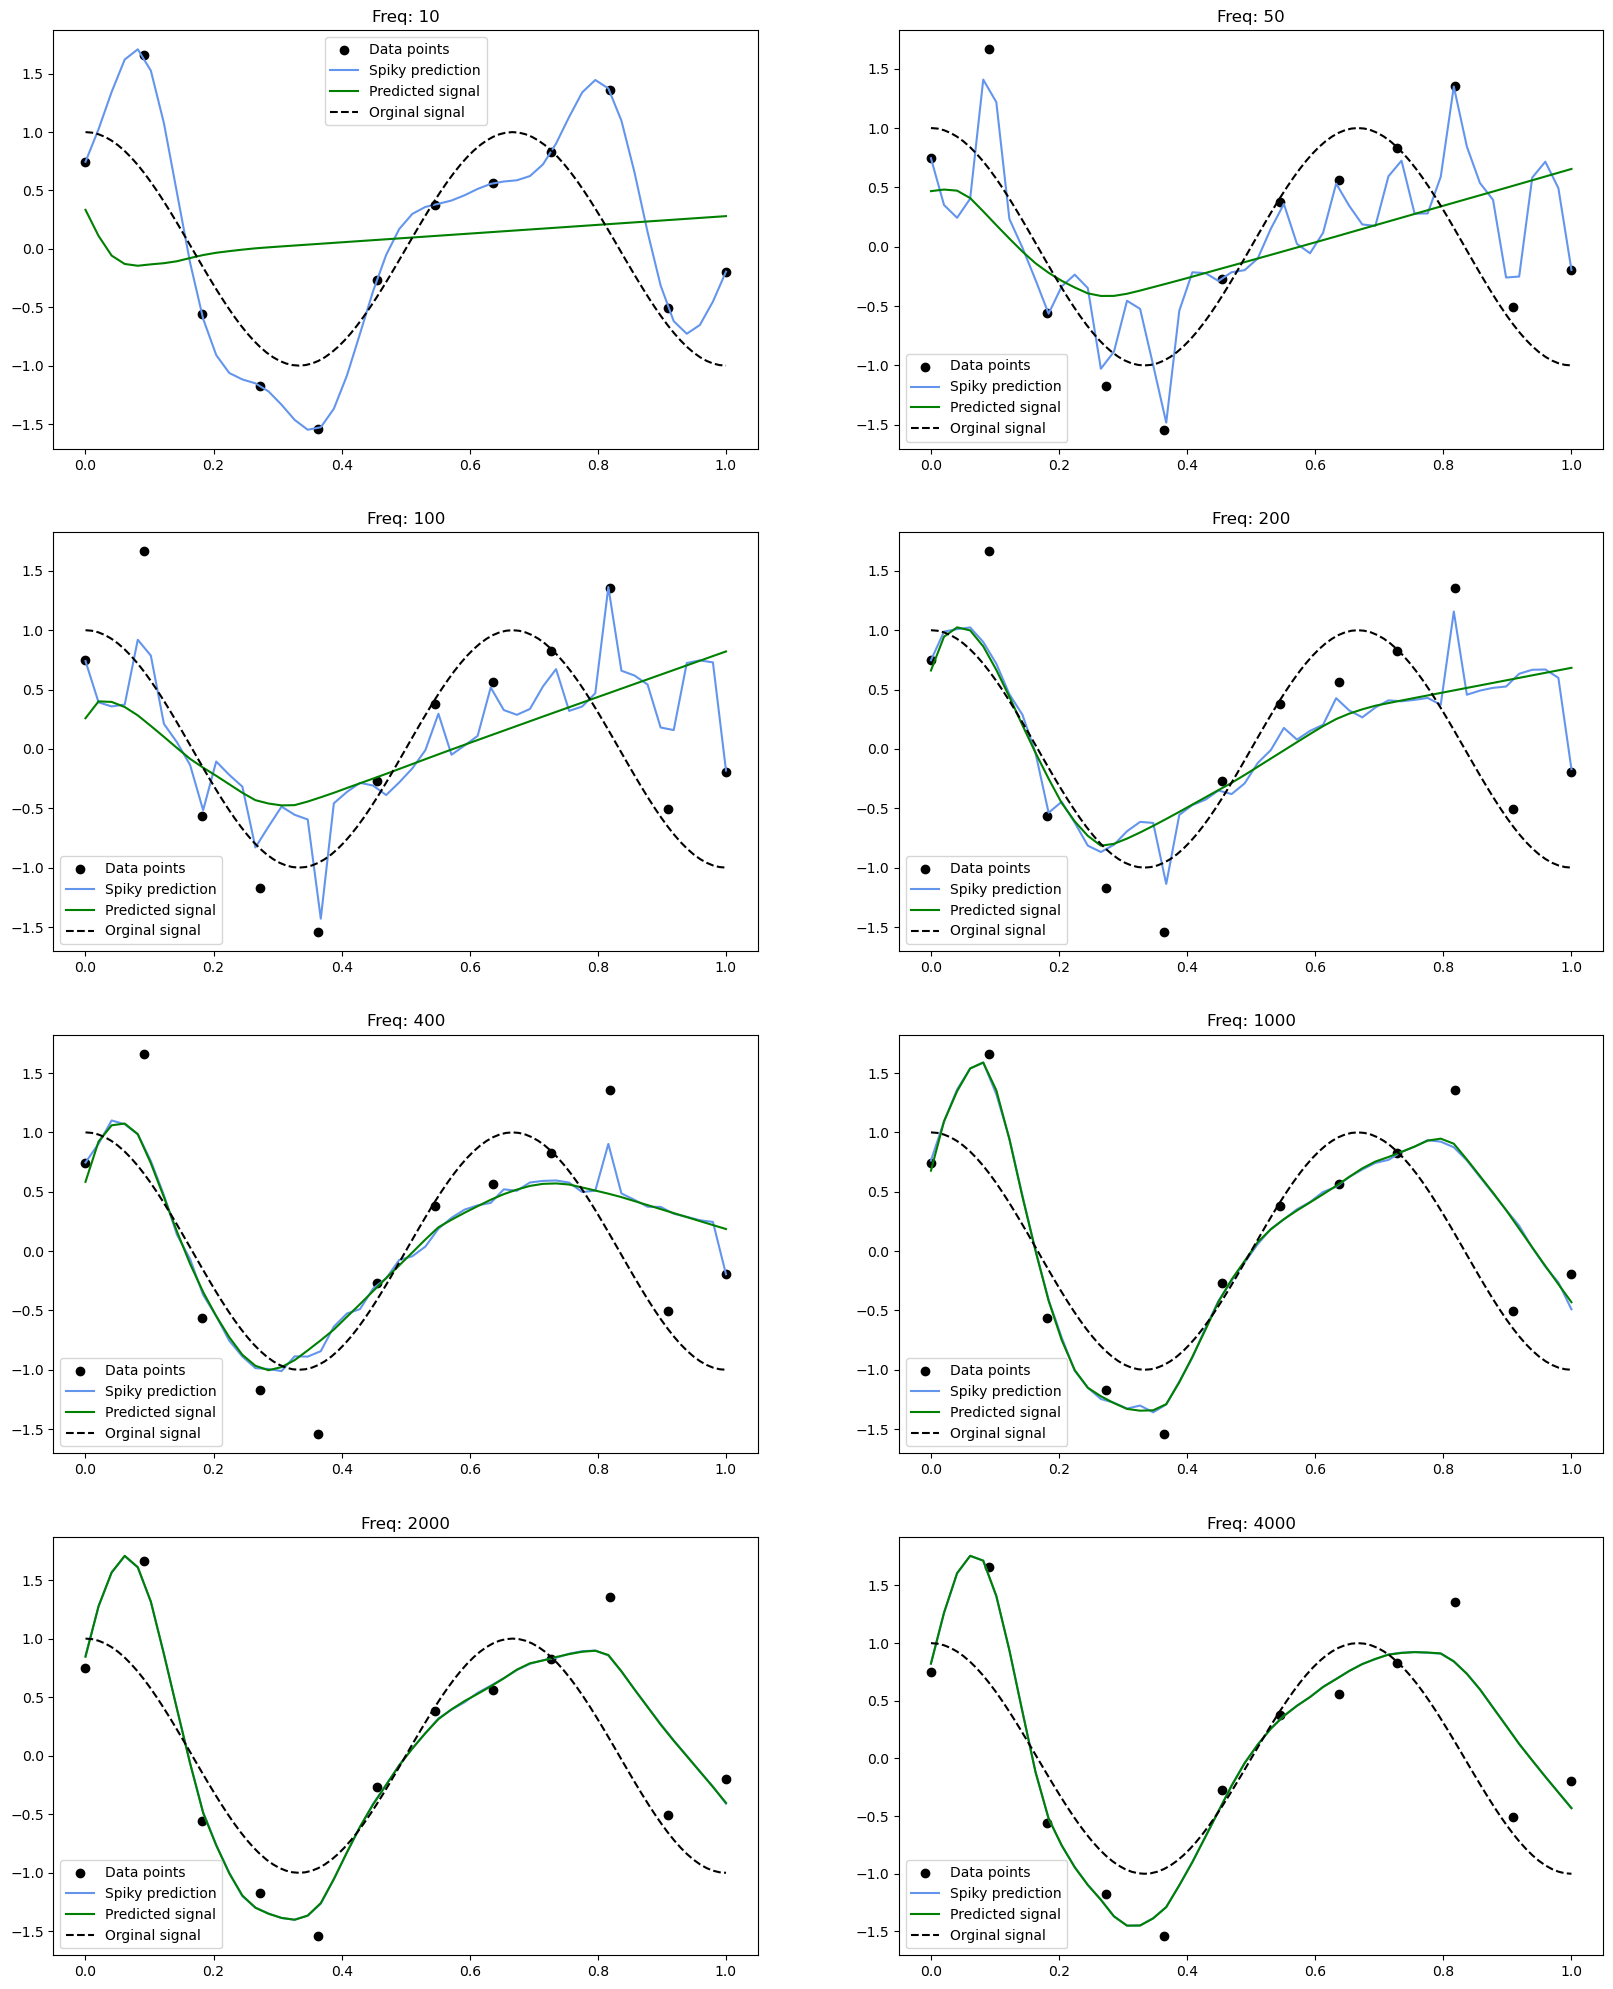

In [67]:
# construct theoretical signal 
x_ = np.linspace(0, 1., 100)
y_ = np.cos(x_ * 2 * omega * np.pi)

x = testing_points.reshape(len(testing_points))

fig, ax = plt.subplots(4, 2, figsize=(20, 25))

axis_ = [(i, j) for i in range(4) for j in range(2)]

for index, ax_index in enumerate(axis_):

    ax[ax_index].scatter(X, y, color="black", label="Data points")
    ax[ax_index].plot(x, raw_pred[index], color="cornflowerblue", label="Spiky prediction")
    ax[ax_index].plot(x, signal_pred[index], color="green", label="Predicted signal")
    ax[ax_index].plot(x_, y_, color="black", linestyle="--", label="Orginal signal")
    ax[ax_index].set_title(f"Freq: {freq[index]}")

    ax[ax_index].legend()

- Optimiser les paramètres
- Tracer les train loss et test loss 
- Tracer sur un même graphique l'incertitude / la variance pour se rendre compte